In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import st_remux as st

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical



%matplotlib inline

Using TensorFlow backend.
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/trial_env/l

In [2]:
# Config
# highpath = 'datasets/high.csv'
# lowpath = 'datasets/none.csv'
# hi = st.raw_to_arr(high, fs, win_len, 0)
# lo = st.raw_to_arr(low, fs, win_len, 0)
highdir = 'datasets/high'
meddir = 'datasets/med'
lowdir = 'datasets/low'
nonedir = 'datasets/none'



fs = 4000
win_len = 40

use_filter = 0   # weird results if we use python filtering

use_matlab_backend = 0

In [3]:
if use_matlab_backend:
    print('Using MATLAB signal processing backend')
    # high_dir = 'datasets/high/'
    # low_dir = 'datasets/low/'

    high_dir = 'C:/Users/Geoffrey/Documents/MATLAB/S transform time frequency/high/'
    low_dir = 'C:/Users/Geoffrey/Documents/MATLAB/S transform time frequency/low/'

    def generate_3darray(directory):
        files = os.listdir(directory)
        dims = np.genfromtxt(directory + files[0], delimiter=',').shape
        length = len(files)
        arr = np.zeros((length, dims[0], dims[1]))

        for idx, val in enumerate(files):
            arr[idx] = np.genfromtxt(directory + val, delimiter=',')

        return arr

    hi = generate_3darray(high_dir)
    lo = generate_3darray(low_dir)
    
else: 
    print('Using native backend')
    hi = st.raw_to_arr(highdir, fs, win_len, 0)
    med = st.raw_to_arr(meddir, fs, win_len, 0)
    lo = st.raw_to_arr(lowdir, fs, win_len, 0)
    none = st.raw_to_arr(nonedir, fs, win_len, 0)

Using native backend


In [4]:
X = np.concatenate((hi, med, lo, none))
d= X.shape
print(d)

hi_Y = np.ones(len(hi), dtype=int) * 3
med_Y = np.ones(len(med), dtype=int) * 2
lo_Y = np.ones(len(lo), dtype=int) * 1
none_Y = np.zeros(len(none), dtype=int)

Y = np.concatenate((hi_Y, med_Y, lo_Y, none_Y))

(23470, 16, 40)


In [5]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.1)

In [6]:
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Testing data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (21123, 16, 40) (21123,)
Testing data shape:  (2347, 16, 40) (2347,)


In [7]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs: ', nClasses)
print('Output classes: ', classes)

Total number of outputs:  4
Output classes:  [0 1 2 3]


Text(0.5,1,'Ground Truth: 2')

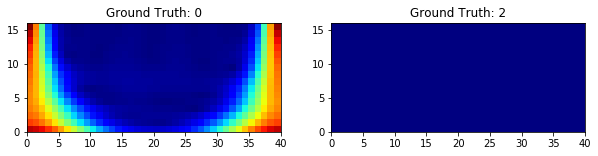

In [8]:
plt.figure(figsize=[10,2])

# Display first image in training set
plt.subplot(121)
plt.pcolormesh(train_X[0,:,:], cmap='jet')
plt.title("Ground Truth: {}".format(train_Y[0]))

# Display second image in testing set
plt.subplot(122)
plt.pcolormesh(test_X[1], cmap='jet')
plt.title("Ground Truth: {}".format(test_Y[1]))

In [16]:
ydim = train_X[0].shape[0]
xdim = train_X[0].shape[1]
train_X = train_X.reshape(-1, ydim, xdim, 1)
test_X = test_X.reshape(-1, ydim, xdim, 1)
train_X.shape, test_X.shape

((16898, 16, 40, 1), (2347, 16, 40, 1))

In [10]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [11]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# See the difference?
print('Original label: ', train_Y[0])
print('After conversion to one-hot: ', train_Y_one_hot[0])

Original label:  0
After conversion to one-hot:  [1. 0. 0. 0.]


In [12]:
train_Y_one_hot.shape

(21123, 4)

In [13]:
from sklearn.model_selection import train_test_split

# Here I split original training data to sub-training (80%) and validation data (20%)
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

# Check the data size whether it is as per tensorflow and VGG19 requirement
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((16898, 16, 40, 1), (4225, 16, 40, 1), (16898, 4), (4225, 4))

In [14]:
from keras.applications import VGG19

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (16, 40, 1), classes = 4)

ValueError: The input must have 3 channels; got `input_shape=(16, 40, 1)`

In [ ]:
vgg19.summary()

In [ ]:
from keras.applications.vgg19 import preprocess_input

# Preprocessing the input 
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X = preprocess_input(test_X)


In [ ]:
train_features = vgg19.predict(np.array(train_X), batch_size=256, verbose=1)
test_features = vgg19.predict(np.array(test_X), batch_size=256, verbose=1)
val_features = vgg19.predict(np.array(valid_X), batch_size=256, verbose=1)

In [ ]:
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y_one_hot)
np.savez("val_features", val_features, valid_label)

In [ ]:
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

In [ ]:
train_features = np.reshape(train_features, (48000, 4*4*512))
test_features = np.reshape(test_features, (10000, 4*4*512))
val_features = np.reshape(val_features, (12000, 4*4*512))

In [ ]:
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

In [ ]:
import keras

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_features, train_label,
          batch_size=256,
          epochs=50,
          verbose=1,
          validation_data=(val_features, valid_label))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()